<a href="https://colab.research.google.com/github/Voland24/AI_Specialization_for_Medicine/blob/main/ChestXRayDiagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook, as well as all of the following ones will be dedicated to exploring the application of Deep learning methods to the field of medicine.
In this particular notebook, we will explore a real-world chest Xray dataset, retrain a DenseNET model via transfer learning for image classification on XRays, handle class imbalance, measure performance via ROC and AUC cruves and visualize the model via GradCams

In [76]:
!pip install keras.util

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for keras.util: filename=keras_util-0.0.2-py3-none-any.whl size=2141 sha256=b92f62733ed168acc3cc333cfbef0dd1a3bea40015308f0ff6813f5922b0d268
  Stored in directory: /root/.cache/pip/wheels/08/f1/91/c1a2451bb7da90657a56958ba3988263db52ee106bd3a5fd89
Successfully built keras.util


In [19]:
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107747 sha256=676f176c7baaee5954cd43dd1bfa85cd90d7c7a9efce5e8d4bcfc2b31c96f490
  Stored in directory: /root/.cache/pip/wheels/7b/26/a5/8460416695a992a2966b41caa5338e5e7fcea98c9d032d055c
Successfully built eli5


Let's first import the neccessary packages.

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K
import eli5
from keras.models import load_model
import tensorflow as tf
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity
random.seed(a=None, version=2)

set_verbosity(INFO)


def get_mean_std_per_batch(image_path, df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["Image"].values):
        # path = image_dir + img
        sample_data.append(
            np.array(tf.keras.utils.load_img(image_path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std


def load_image(img, image_dir, df, preprocess=True, H=320, W=320):
    """Load and preprocess image."""
    img_path = image_dir + img
    mean, std = get_mean_std_per_batch(img_path, df, H=H, W=W)
    x = tf.keras.utils.load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x


def grad_cam(input_model, image, cls, layer_name, H=320, W=320):
    """GradCAM method for visualizing input saliency."""
    # y_c = input_model.output[0, cls]
    # conv_output = input_model.get_layer(layer_name).output
    # grads = K.gradients(y_c, conv_output)[0]

    # gradient_function = K.function([input_model.input], [conv_output, grads])

    # output, grads_val = gradient_function([image])
    # output, grads_val = output[0, :], grads_val[0, :, :, :]

    # weights = np.mean(grads_val, axis=(0, 1))
    # cam = np.dot(output, weights)

    # # Process CAM
    # cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    # cam = np.maximum(cam, 0)
    # cam = cam / cam.max()
    # return cam
    y_c = input_model.output[0, cls]
    doc = tf.keras.utils.img_to_array(image[0])
    # doc = np.expand_dims(doc, axis=0)
    eli5.show_prediction(input_model,doc, targets=[y_c]) 


def compute_gradcam(model, img, image_dir, df, labels, selected_labels,
                    layer_name='bn'):
    preprocessed_input = load_image(img, image_dir, df)
    predictions = model.predict(preprocessed_input)

    print("Loading original image")
    plt.figure(figsize=(15, 10))
    plt.subplot(151)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(load_image(img, image_dir, df, preprocess=False), cmap='gray')

    j = 1
    for i in range(len(labels)):
        if labels[i] in selected_labels:
            print(f"Generating gradcam for class {labels[i]}")
            gradcam = grad_cam(model, preprocessed_input, i, layer_name)
            plt.subplot(151 + j)
            plt.title(f"{labels[i]}: p={predictions[0][i]:.3f}")
            plt.axis('off')
            plt.imshow(load_image(img, image_dir, df, preprocess=False),
                       cmap='gray')
            plt.imshow(gradcam, cmap='jet', alpha=min(0.5, predictions[0][i]))
            j += 1


def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals

labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

IMAGE_DIR ='/content/images_small/'


The dataset comprises of 100k chest xray images of front facing patients. Each image has mutiple labels in text form of 14 different pathological conditions. These help physicians determine 8 different diseases. We will develop a binary classification algorithm for each of the 14 labeled pathologies. This will tell the doctors whether or not a certain pathology is present in the chest xray.

The dataset we will use is 1k images ffrom the original dataset. Accompanying the dataset are three files in csv. These are the labels for the images. There are the train/val/test datasets. These encompass 5 of 14 different pathologies present. These are Consolidation, Edema, Effusion, Cardiomegaly, Atelectasis.

In [97]:
!unzip /content/images-small.zip

Archive:  /content/images-small.zip
replace images-small/00000003_001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace images-small/00000020_001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
train_df = pd.read_csv('/content/train-small.csv')
valid_df = pd.read_csv('/content/valid-small.csv')
test_df = pd.read_csv('/content/test.csv')

In [33]:
train_df.head(2)

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0


In [34]:
train_df.columns

Index(['Image', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
       'Nodule', 'PatientId', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'],
      dtype='object')

Data leakgage
The problem arises when there is info shared between the train/val/test datasets that can give an illusion of a better performance. Here, this can happen because there are multiple xrays for the same patient. This has happened simply because a given patient could have had his/her xray taken a different times, during different hospital visits. So we will write a function that ensures that there is no data leakage i.e. there is not a patient that occurs in the test dataset that is also in the train/val dataset.

In [3]:
def check_for_leakage(df1, df2, patient_col):
  #patient col is the column name for the patient id

  df1_patient_unique = set(df1[patient_col].unique())
  df2_patient_unique = set(df2[patient_col].unique())
  return True if df1_patient_unique.intersection(df2_patient_unique) else False


  

Let's now check for leakage between test and val sets as well as test and train sets

In [4]:
check_for_leakage(train_df, test_df, 'PatientId')

False

In [5]:
check_for_leakage(valid_df, test_df, 'PatientId')

False

There is no leakage and we can safely continue.

We will use the ImageGenerator from keras to build a generator for the images in our dataset. This also allows us an easy way to perform basic data augmentation of the images, such as random horizontal flipping and more. This also allows us to transform the pixel values of the images in batch so that their mean is 0 and their stand dev is 1 which greatly aids in the training process. The generator will also convert the images from the grayscale format to the three channel format by copying the image three times, since that is the input shape that our model expects and has been trained on. 

The generator will normalize the mean and stand dev of the batch data. It will shuffle the data after each epoch. And it will resize the images to the size of 320 by 320px.

 This is the train data generator.

In [6]:
def get_train_generator(df, image_dir,x_col, y_cols, shuffle=True,batch_size=8,seed=42,target_w=320,target_h=320):
  """
  train_df (dataframe): dataframe specifying training data.
  image_dir (str): directory where image files are held.
  x_col (str): name of column in df that holds filenames.
  y_cols (list): list of strings that hold y labels for images.
  batch_size (int): images per batch to be fed into model during training.
  seed (int): random seed.
  target_w (int): final width of input images.
  target_h (int): final height of input images.
  Returns:
        train_generator (DataFrameIterator): iterator over training set
  """
  image_generator = ImageDataGenerator(samplewise_center=True,samplewise_std_normalization=True)
  generator = image_generator.flow_from_dataframe(
              dataframe=df,
              directory=image_dir,
              x_col=x_col,
              y_col = y_cols,
              class_mode='raw',
              batch_size=batch_size,
              shuffle=shuffle,
              seed=seed,
              target_size=(target_w, target_h)
  )
  return generator
#Consolidation, Edema, Effusion, Cardiomegaly, Atelectasis

We will now build separate generators for the val and test datasets. Why? Because, we compute the mean and std dev of the dataset to standardize a batch in the training. We do not have this info in the val and test datasets since the data isn't coming in batches but one at a time. We do not have this information and knowing the mean and std dev of the val or test batches would hinder a realistic imppression of the model's performance.

So we will use the mean and std of the training dataset in a real world scenario. However, instead of computing the mean and std dev of the entire training dataset, as we would in practice, here we will compute the mean and std dev ona single randomly chosen example from the training dataset and use it to standardize the val and test data.

In [7]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=image_dir, 
        x_col="Image", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
  
    batch = raw_train_generator.next()
    data_sample = batch[0]

    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True
    )
    image_generator.fit(data_sample)

    valid_generator = image_generator.flow_from_dataframe(
        dataframe=valid_df,
        directory=image_dir,
        x_col=x_col,
        y_col=y_cols,
        class_mode="raw",
        batch_size=batch_size,
        shuffle=False,
        seed=seed,
        target_size=(target_w,target_h)
    )
    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    
    return valid_generator, test_generator



In [8]:
train_generator = get_train_generator(train_df, '/content/images-small/', "Image", labels)
valid_generator, test_generator = get_test_and_valid_generator(valid_df, test_df, train_df, '/content/images-small/', "Image", labels)


Found 1000 validated image filenames.
getting train and valid generators...
Found 1000 validated image filenames.
Found 1 validated image filenames.
Found 420 validated image filenames.


/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 108 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  warnings.warn(


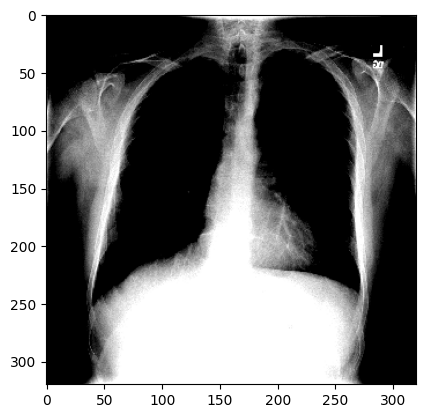

In [9]:
x,y = train_generator.__getitem__(0)
plt.imshow(x[0])

One of the biggest problems with working on medical datasets is the imbalance of classes present in the dataset. Let's see what this actually means

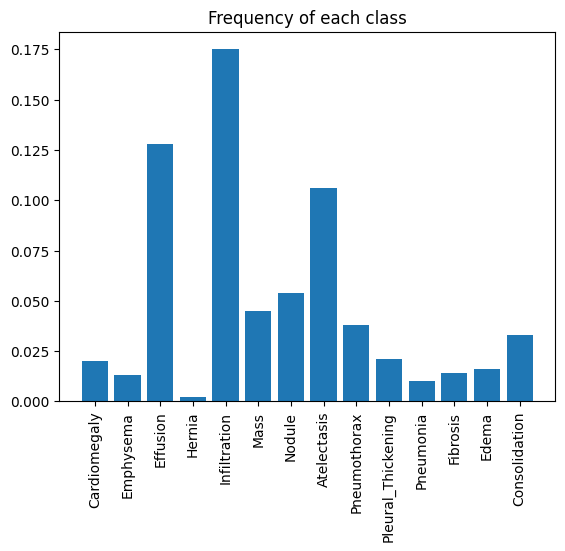

In [54]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title('Frequency of each class')
plt.show()

What we can see from this graph is the class imbalance in the dataset across different pathologies. Here we are disscussing the number of positive and negative examples of each pathology in each of them given. We can see that the Hernia pathology has the greates imbalance, with only 2% of Hernia examples being 1. Infiltration has the smalles imbalance with 17.5% percent being positive, but even that is too small. This means that only 17.5% of examples have been identified as having hernia while all of the rest are negative examples.

Ideally, we would want a dataset in which both cases, both positive and negative, contribute equally to the classifier loss. What this means can be seen in the following examples. Consider we are using a normal cross entropy loss function with a dataset that is highly unbalanced.

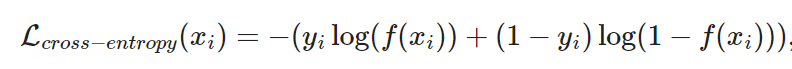

This is how the normal cross entropy loss function looks like. This means that each of the training examples, being either 0 or 1, will contribute to the loss function with its term, while the other term will be neagted. If y=0, only the second term applies. This will cause a poor performance of the model since it will be incentivized to prioritize on the majority class, in this case, it being class 0 for each pathology.

Let's compute class frequencies for our dataset per pathology.

In [10]:
def compute_class_frequencies(labels):
  N = labels.shape[0] #total number of patients
  pos_freqs = np.sum(labels, axis=0) / N
  neg_freqs = 1 - pos_freqs
  return pos_freqs, neg_freqs

In [11]:
freq_pos, freq_neg = compute_class_frequencies(train_generator.labels)

<ipython-input-12-5144b4a21050>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)


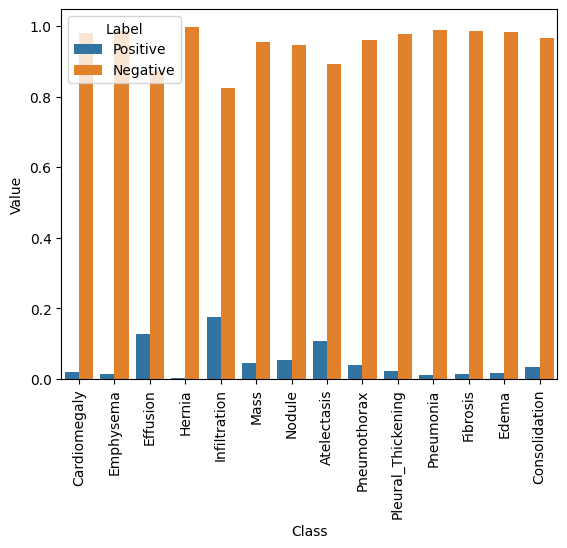

In [12]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

We can see that the contribution of the negative classes is much much greater than the positive ones. We would like this contribution to be equal among each class. We will achieve this by a class specific weight factor, so that the overall contribution is the same. 

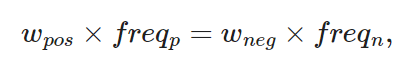

We would like this equation to hold true. The easiest way to achieve this is to set the wpos to freq_neg and vice-versa i.e.
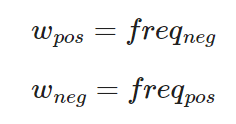

In [13]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights
neg_contribution = freq_neg * neg_weights


<ipython-input-14-3f29518afd0d>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v}


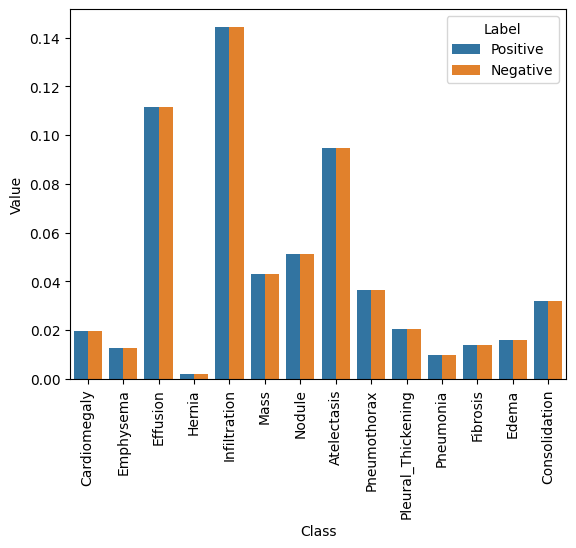

In [14]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

We can see that by applying this weight factor, each class would contribute the same ammount to the loss function.
Such a loss function would look fairly simple and it is given here 
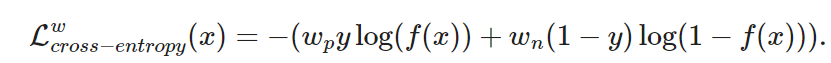

We can see that we are only multiplying each of the loss terms by its given weights as to ensure the class imbalance problem is nonexistent.

In [15]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
  def weighted_loss(y_true, y_pred):
    loss = 0.0
    for i in range(len(pos_weights)):
      term_1 = pos_weights[i] * y_true[:,i] * K.log(y_pred[:,i] + epsilon)
      term_2 = neg_weights[i] * (1 - y_true[:,i]) * K.log( 1 - y_pred[:,i] + epsilon)
      term_3 = -1 * (term_1 + term_2)
      loss+= np.mean(term_3)
    return loss
  
  return weighted_loss
    

We will be using a DenseNet model loaded directly from Keras and we will be adding two more layers on top of it, at the end.
One, a global average pooling 2d layer, which will give us the average from the last convolutional layer from the DenseNet121
A the second one, a fully connected Dense layer with a sigmoid function at the end to serve as our classification network.

In [16]:
base_model = DenseNet121(weights='imagenet', include_top=False)

x = base_model.output

x = GlobalAveragePooling2D()(x)
predictions = Dense(len(labels), activation="sigmoid")(x)
model=Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss = get_weighted_loss(pos_weights, neg_weights))

Although the model will not be trained here due to time and resource limitations, this code can be used for training the model if needed.

In [ ]:
history = model.fit_generator(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=100, 
                              validation_steps=25, 
                              epochs = 3)

plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

We will load a pretrained model. The original dataset in 40GB in size so the training takes a few hours on multiple GPU which I do not have. Batch size was 32 in training.

In [17]:
model.load_weights("/content/cxr_naveen.h5")

Let's now make some prediction with this given model.

In [18]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

<ipython-input-18-4bf3896b317d>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))


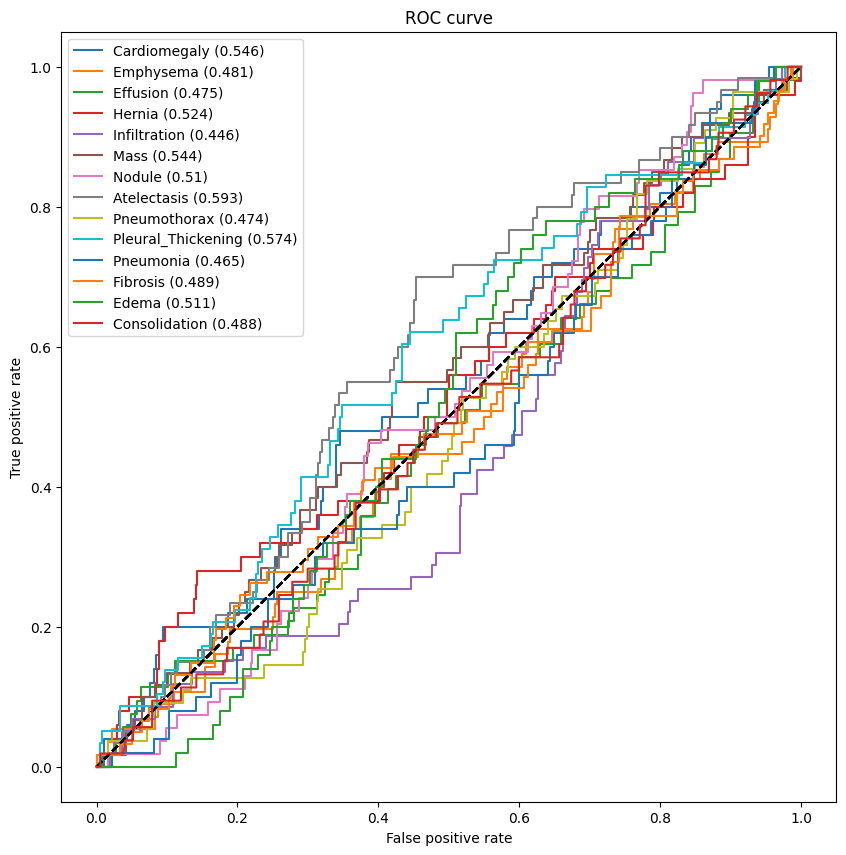

In [22]:
auc_rocs = get_roc_curve(labels, predicted_vals, test_generator)

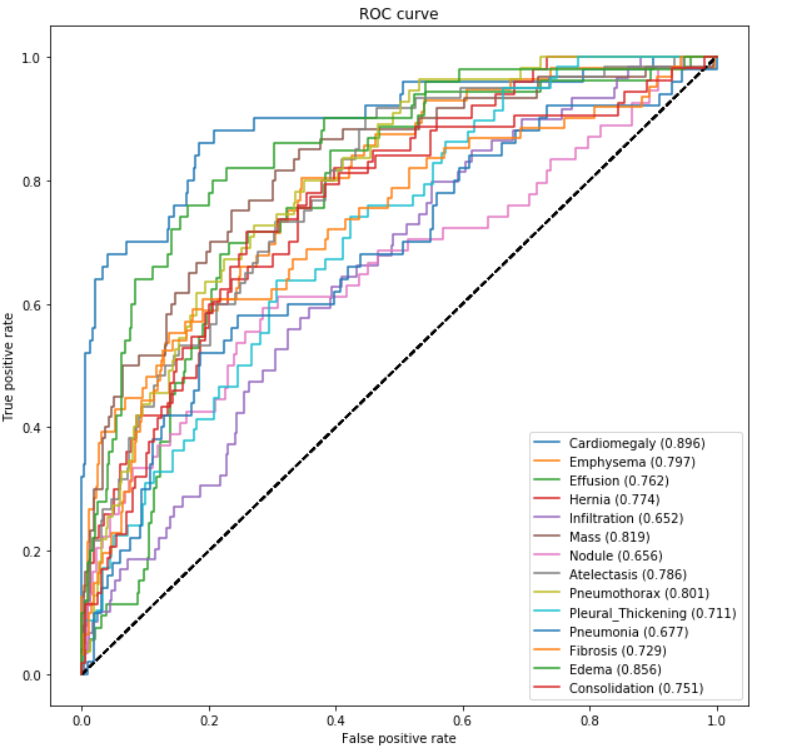

In [39]:
df = pd.read_csv("/content/train-small.csv")
IMAGE_DIR = "/content/images-small/"

# only show the labels with top 4 AUC
labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]

In [ ]:
compute_gradcam(model, '00011355_002.png', IMAGE_DIR, df, labels, labels_to_show)

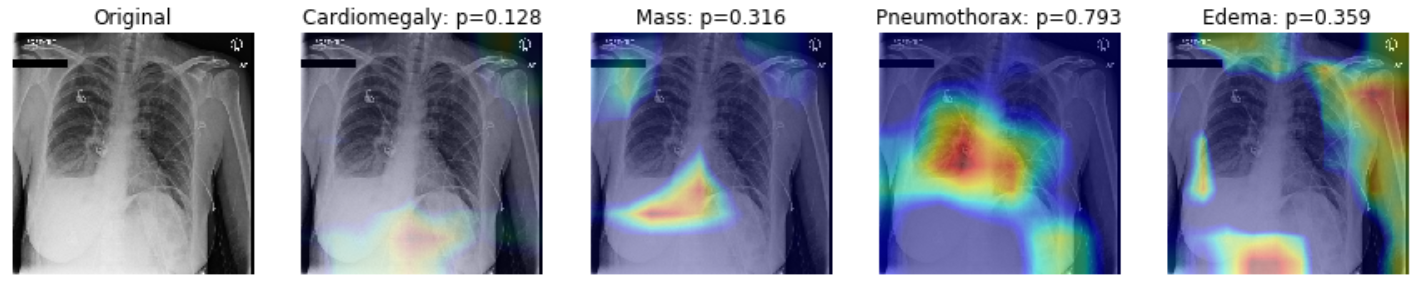